<a href="https://colab.research.google.com/github/Parinita-Jain/Getting-Started-with-NLP/blob/main/SpamClassification_using_FineTuningBertTransformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [65]:
import torch
if torch.cuda.is_available():
  device=torch.device("cuda")

In [66]:
!pip install transformers

In [67]:
from transformers import BertModel
bert=BertModel.from_pretrained("bert-base-uncased")
from transformers import BertTokenizerFast
tokenizer=BertTokenizerFast.from_pretrained("bert-base-uncased",do_lower_case=True)

In [68]:
import pandas as pd
import numpy as np
import re

In [69]:
df=pd.read_csv("spam.csv")
df.head()
df["Category"].value_counts()

not spam    4825
spam         747
Name: Category, dtype: int64

In [70]:
def preprocessor(text):
  text=text.lower()
  text=re.sub(r"[^a-zA-Z ]+"," ",text)
  text=re.sub(r"[\s]+"," ",text)
  return text

In [71]:
df["Message"]=df["Message"].apply(preprocessor)
text=df["Message"]
labels=df["Category"]

In [72]:
from sklearn.preprocessing import LabelEncoder
le=LabelEncoder()
labels=le.fit_transform(labels)

Text(0.5, 1.0, 'Histogram: Length of sentences')

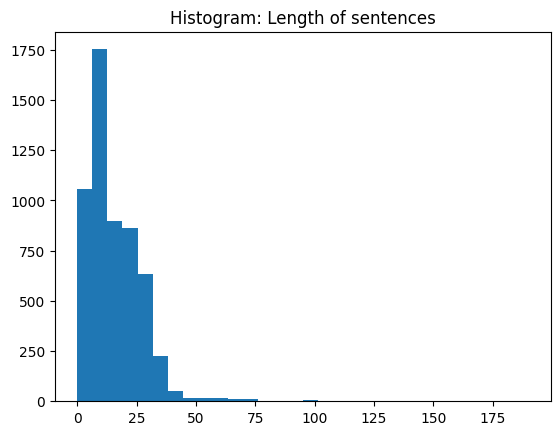

In [73]:
# library for visualization
import matplotlib.pyplot as plt

# compute no. of words in each tweet
num = [len(i.split()) for i in text]

plt.hist(num, bins = 30)

plt.title("Histogram: Length of sentences")

In [74]:
l=[]
for i in text:
  l.append(len(i.split()))
maxlength=int(np.quantile(l,0.95))
maxlength

33

In [75]:
sent_id=[]
for i in range(len(text)):
  encoded_sent=tokenizer.encode(text[i],add_special_tokens=True,max_length=maxlength,truncation=True,
                                pad_to_max_length="right")
  sent_id.append(encoded_sent)

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2393: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [76]:
attention_masks=[]
for sent in sent_id:
  att_mask=[int(token_id>0) for token_id in sent]
  attention_masks.append(att_mask)

In [77]:

from sklearn.model_selection import train_test_split

train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(sent_id, labels, random_state=2018, test_size=0.1, stratify=labels)

train_masks, validation_masks, _, _ = train_test_split(attention_masks, labels, random_state=2018, test_size=0.1, stratify=labels)


In [78]:

train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)

train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)

train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

In [79]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
batch_size = 32

train_data = TensorDataset(train_inputs, train_masks, train_labels)

train_sampler = RandomSampler(train_data)

train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)

validation_sampler = SequentialSampler(validation_data)

validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)


In [80]:
#create an iterator object
iterator = iter(train_dataloader)

#loads batch data
sent_id, mask, target=next(iterator)


In [81]:
#pass inputs to the model
outputs = bert(sent_id,             #integer sequence
               attention_mask=mask, return_dict=False) #attention masks

In [82]:
# hidden states
hidden_states = outputs[0]

# [CLS] hidden state
CLS_hidden_state = outputs[1]

print("Shape of Hidden States:",hidden_states.shape)
print("Shape of CLS Hidden State:",CLS_hidden_state.shape)

Shape of Hidden States: torch.Size([32, 33, 768])
Shape of CLS Hidden State: torch.Size([32, 768])


In [83]:
# turn off the gradient of all the parameters
for param in bert.parameters():
    param.requires_grad = False

In [85]:

#importing nn module
import torch.nn as nn

class classifier(nn.Module):

    #define the layers and wrappers used by model
    def __init__(self, bert):

      #constructor
      super(classifier, self).__init__()

      #bert model
      self.bert = bert

      # dense layer 1
      self.fc1 = nn.Linear(768,512)

      #dense layer 2 (Output layer)
      self.fc2 = nn.Linear(512,2)

      #dropout layer
      self.dropout = nn.Dropout(0.1)

      #relu activation function
      self.relu =  nn.Tanh()

      #softmax activation function
      self.softmax = nn.Softmax(dim=1)

    #define the forward pass
    def forward(self, sent_id, mask):

      #pass the inputs to the model
      all_hidden_states, cls_hidden_state = self.bert(sent_id, attention_mask=mask, return_dict=False)

      #pass CLS hidden state to dense layer
      x = self.fc1(cls_hidden_state)

      #Apply ReLU activation function
      x = self.relu(x)

      #Apply Dropout
      x = self.dropout(x)

      #pass input to the output layer
      x = self.fc2(x)

      #apply softmax activation
      x = self.softmax(x)

      return x


#create the model
model = classifier(bert)

#push the model to GPU, if available
model = model.to(device)


#model architecture
model

classifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine

In [86]:

# push the tensors to GPU
sent_id = sent_id.to(device)
mask = mask.to(device)
target = target.to(device)

# pass inputs to the model
outputs = model(sent_id, mask)

In [88]:

# Adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

In [89]:

#library for array processing
import numpy as np

#library for computing class weights
from sklearn.utils.class_weight import compute_class_weight

#compute the class weights
#class_weights = compute_class_weight('balanced', np.unique(labels), y=labels)
class_weights = compute_class_weight(class_weight = "balanced", classes= np.unique(labels), y= labels)

print("Class Weights:",class_weights)


Class Weights: [0.57740933 3.72958501]


In [90]:
# converting a list of class weights to a tensor
weights= torch.tensor(class_weights,dtype=torch.float)

# transfer to GPU
weights = weights.to(device)

# define the loss function
cross_entropy  = nn.NLLLoss(weight=weights)

In [91]:

#compute the loss
print(target)
loss = cross_entropy(outputs, target)
print("Loss:",loss)

tensor([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0,
        0, 1, 0, 1, 0, 0, 0, 0], device='cuda:0')
Loss: tensor(-0.5001, device='cuda:0', grad_fn=<NllLossBackward0>)


In [92]:
import time
import datetime

# compute time in hh:mm:ss
def format_time(elapsed):
    # round to the nearest second.
    elapsed_rounded = int(round((elapsed)))

    # format as hh:mm:ss
    return str(datetime.timedelta(seconds = elapsed_rounded))

In [93]:
#define a function for training the model
def train():

  print("\nTraining.....")

  #set the model on training phase - Dropout layers are activated
  model.train()

  #record the current time
  t0 = time.time()

  #initialize loss and accuracy to 0
  total_loss, total_accuracy = 0, 0

  #Create a empty list to save the model predictions
  total_preds=[]

  #for every batch
  for step,batch in enumerate(train_dataloader):

    # Progress update after every 40 batches.
    if step % 40 == 0 and not step == 0:

      # Calculate elapsed time in minutes.
      elapsed = format_time(time.time() - t0)

      # Report progress.
      print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

    #push the batch to gpu
    batch = tuple(t.to(device) for t in batch)

    #unpack the batch into separate variables
    # `batch` contains three pytorch tensors:
    #   [0]: input ids
    #   [1]: attention masks
    #   [2]: labels
    sent_id, mask, labels = batch

    # Always clear any previously calculated gradients before performing a
    # backward pass. PyTorch doesn't do this automatically.
    model.zero_grad()

    # Perform a forward pass. This returns the model predictions
    preds = model(sent_id, mask)

    #compute the loss between actual and predicted values
    loss =  cross_entropy(preds, labels)

    # Accumulate the training loss over all of the batches so that we can
    # calculate the average loss at the end. `loss` is a Tensor containing a
    # single value; the `.item()` function just returns the Python value
    # from the tensor.
    total_loss = total_loss + loss.item()

    # Perform a backward pass to calculate the gradients.
    loss.backward()

    # Update parameters and take a step using the computed gradient.
    # The optimizer dictates the "update rule"--how the parameters are
    # modified based on their gradients, the learning rate, etc.
    optimizer.step()

    #The model predictions are stored on GPU. So, push it to CPU
    preds=preds.detach().cpu().numpy()

    #Accumulate the model predictions of each batch
    total_preds.append(preds)

  #compute the training loss of a epoch
  avg_loss     = total_loss / len(train_dataloader)

  #The predictions are in the form of (no. of batches, size of batch, no. of classes).
  #So, reshaping the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  #returns the loss and predictions
  return avg_loss, total_preds


In [94]:
#define a function for evaluating the model
def evaluate():

  print("\nEvaluating.....")

  #set the model on training phase - Dropout layers are deactivated
  model.eval()

  #record the current time
  t0 = time.time()

  #initialize the loss and accuracy to 0
  total_loss, total_accuracy = 0, 0

  #Create a empty list to save the model predictions
  total_preds = []

  #for each batch
  for step,batch in enumerate(validation_dataloader):

    # Progress update every 40 batches.
    if step % 40 == 0 and not step == 0:

      # Calculate elapsed time in minutes.
      elapsed = format_time(time.time() - t0)

      # Report progress.
      print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(validation_dataloader), elapsed))

    #push the batch to gpu
    batch = tuple(t.to(device) for t in batch)

    #unpack the batch into separate variables
    # `batch` contains three pytorch tensors:
    #   [0]: input ids
    #   [1]: attention masks
    #   [2]: labels
    sent_id, mask, labels = batch

    #deactivates autograd
    with torch.no_grad():

      # Perform a forward pass. This returns the model predictions
      preds = model(sent_id, mask)

      #compute the validation loss between actual and predicted values
      loss = cross_entropy(preds,labels)

      # Accumulate the validation loss over all of the batches so that we can
      # calculate the average loss at the end. `loss` is a Tensor containing a
      # single value; the `.item()` function just returns the Python value
      # from the tensor.
      total_loss = total_loss + loss.item()

      #The model predictions are stored on GPU. So, push it to CPU
      preds=preds.detach().cpu().numpy()

      #Accumulate the model predictions of each batch
      total_preds.append(preds)

  #compute the validation loss of a epoch
  avg_loss = total_loss / len(validation_dataloader)

  #The predictions are in the form of (no. of batches, size of batch, no. of classes).
  #So, reshaping the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  return avg_loss, total_preds

In [95]:
#Assign the initial loss to infinite
best_valid_loss = float('inf')

#create a empty list to store training and validation loss of each epoch
train_losses=[]
valid_losses=[]

epochs = 5

#for each epoch
for epoch in range(epochs):

    print('\n....... epoch {:} / {:} .......'.format(epoch + 1, epochs))

    #train model
    train_loss, _ = train()

    #evaluate model
    valid_loss, _ = evaluate()

    #save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'saved_weights.pt')

    #accumulate training and validation loss
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)

    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')

print("")
print("Training complete!")



....... epoch 1 / 5 .......

Training.....
  Batch    40  of    157.    Elapsed: 0:00:02.
  Batch    80  of    157.    Elapsed: 0:00:05.
  Batch   120  of    157.    Elapsed: 0:00:07.

Evaluating.....

Training Loss: -0.569
Validation Loss: -0.706

....... epoch 2 / 5 .......

Training.....
  Batch    40  of    157.    Elapsed: 0:00:02.
  Batch    80  of    157.    Elapsed: 0:00:05.
  Batch   120  of    157.    Elapsed: 0:00:07.

Evaluating.....

Training Loss: -0.798
Validation Loss: -0.884

....... epoch 3 / 5 .......

Training.....
  Batch    40  of    157.    Elapsed: 0:00:03.
  Batch    80  of    157.    Elapsed: 0:00:05.
  Batch   120  of    157.    Elapsed: 0:00:07.

Evaluating.....

Training Loss: -0.851
Validation Loss: -0.876

....... epoch 4 / 5 .......

Training.....
  Batch    40  of    157.    Elapsed: 0:00:02.
  Batch    80  of    157.    Elapsed: 0:00:05.
  Batch   120  of    157.    Elapsed: 0:00:07.

Evaluating.....

Training Loss: -0.882
Validation Loss: -0.845

...

In [96]:
# load weights of best model
path='saved_weights.pt'
model.load_state_dict(torch.load(path))

<All keys matched successfully>

In [97]:

# get the model predictions on the validation data
# returns 2 elements- Validation loss and Predictions
valid_loss, preds = evaluate()
print(valid_loss)


Evaluating.....
-0.906277166472541


In [98]:

# Converting the log(probabities) into a classes
# Choosing index of a maximum value as class
y_pred = np.argmax(preds,axis=1)

# actual labels
y_true = validation_labels


In [99]:
from sklearn.metrics import classification_report
print(classification_report(y_true,y_pred))

              precision    recall  f1-score   support

           0       0.98      0.97      0.97       483
           1       0.82      0.85      0.84        75

    accuracy                           0.96       558
   macro avg       0.90      0.91      0.91       558
weighted avg       0.96      0.96      0.96       558

